### Overview:

In this notebook the insights gained from exploratory analysis are used to help answer the question surrounding proper stocking requirements for Divvy stations. The goal was to create a model to predict the ratio of trips in / trips out of any given station by day of the week and month of the year. This would allow Divvy to compare this predicted ratio with the current stocking status of their stations.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import datetime as dt

In [2]:
df = pd.read_csv('Divvy_data_2017T2.csv')

In [3]:
df.rename(columns={'start_station_trip_count': 'start_trips_whole_year'}, inplace=True)

In [4]:
df.start_time = pd.to_datetime(df.start_time, format='%Y-%m-%d  %H:%M:%S')
df = df.set_index('start_time')
df['month_of_year'] = df.index.month

### First we need to define our target and predictor variables

In [5]:
#find the number of trips leaving each station by day of the week and month of the year
stations_out = df.groupby(['start_station_id', 'day_of_week', 'month_of_year']).count()

#Not all stations had trips arrive at them every single day of the year. These are not currently shown as empty values, data does
#not appear for those days at all. Unstack the month and day of week, to view information for all days, and fill NaN's with 0's.
out = stations_out.unstack(['month_of_year', 'day_of_week'])
out = out.fillna(0)

In [6]:
out.head()

trip_id                                              ...   \
month_of_year         1    2    3    4    5    6    7    8    9    10 ...    
day_of_week            0    0    0    0    0    0    0    0    0    0 ...    
start_station_id                                                      ...    
2                     12   75   51  128  273  322  536  270  330  145 ...    
3                     38  171  107  228  556  477  912  682  614  394 ...    
4                     15  101   28  182  469  399  744  377  431  251 ...    
5                     24   51   35   60  124  147  231  138   95  113 ...    
6                     21   99   41   54  443  398  655  420  417  316 ...    

                 week_of_year                                                 
month_of_year              3    4    5    6     7    8     9    10   11   12  
day_of_week                 6    6    6    6     6    6     6    6    6    6  
start_station_id                                                              
2                          57  293  286  463   749  357   623  162   20   11  
3                         186  585  760  876  1248  796  1020  631  188  113  
4                          74  505  595  867  1052  595   635  369   76   56  
5                          16   63   89  156   197   99    94   89   17   12  
6                         119  404  557  834  1038  759   745  442   66   69  

[5 rows x 2184 columns]

In [7]:
#restack the day and month so we can see the number of trips broken down by these variables with the 0s filled in 
a = out.stack(['day_of_week', 'month_of_year'])

In [8]:
#find the number of trips arriving at each station by day of the week and month of the year
stations_in = df.groupby(['end_station_id', 'day_of_week', 'month_of_year']).count()

#Not all stations had trips leave from them every single day of the year. These are not currently shown as empty values, data does
#not appear for those days at all. Unstack the month and day of week, to view information for all days, and fill NaN's with 0's.
ins = stations_in.unstack(['month_of_year', 'day_of_week'])
ins = ins.fillna(0)

In [9]:
#restack the day and month so we can see the number of trips broken down by these variables with the 0s filled in 
b = ins.stack(['day_of_week', 'month_of_year'])

In [10]:
#create a function to find the trips coming in to trips going out ratio for each station
def io_ratio():
    station_ios = []
    
    #49140 is how many observations there our in our data broken down by station, day of week, and month of the year
    for row in range(0, 49140):
        if int(a.trip_id.iloc[row]) == 0 & int(b.trip_id.iloc[row]) == 0:
            station_ios.append(1)
        elif b.trip_id.iloc[row] == 0:
            station_ios.append(1/a.trip_id.iloc[row])
        elif a.trip_id.iloc[row] == 0:
            station_ios.append(b.trip_id.iloc[row])
        else:
            io = float(b.trip_id.iloc[row]) / a.trip_id.iloc[row]
            station_ios.append(io)
    
    return station_ios


In [11]:
ratio = io_ratio()

In [12]:
#create a function to find the number of trips coming in and coming out of each station by day of the week and month.
def rides():
    rides_in = []
    rides_out =[]
    
    
    #49140 is how many observations there our in our data broken down by station, day of week, and month of the year
    for row in range(0, 49140):
            rides_in.append(b.trip_id.iloc[row])
            rides_out.append(a.trip_id.iloc[row])
    
    return rides_in, rides_out

In [13]:
i, o = rides()

In [14]:
avg_duration = df.groupby(['start_station_id', 'day_of_week', 'month_of_year']).mean()


In [15]:
dur = avg_duration.unstack(['month_of_year', 'day_of_week'])
dur = dur.fillna(0)
ad = dur.stack(['day_of_week', 'month_of_year'])

In [16]:
#create a function to find the number average duration starting from each station by day of the week and month.
def average_duration():
    avgdur = []
    
    
    #49140 is how many observations there our in our data broken down by station, day of week, and month of the year
    for row in range(0, 49140):
            avgdur.append(ad.trip_duration.iloc[row])
    
    return avgdur

avgdur = average_duration()

In [17]:
c = a.reset_index()
c['ratio'] = ratio
c['rides_in'] = i
c['rides_out'] = o
c['average_duration'] = avgdur


In [18]:
#add some additional features
add_features = df.groupby(['start_station_id', 'start_capacity', 'group', 'start_latitude', 'start_longitude' ]).count()
add_features = add_features.reset_index()
add_features = add_features[['start_station_id', 'start_capacity', 'group', 'start_latitude', 'start_longitude']]

In [19]:
af = c.merge(add_features, on='start_station_id')
c['capacity'] = af.start_capacity_y
c['group'] = af.group_y
c['latitude'] = af.start_latitude_y
c['longitude'] = af.start_longitude_y

In [20]:
c['start_station_id'] = c['start_station_id'].astype(float)
c['day_of_week'] = c['day_of_week'].astype(float)
c['month_of_year'] = c['month_of_year'].astype(float)
c['rides_in'] = c['rides_in'].astype(float)
c['rides_out'] = c['rides_out'].astype(float)
c['capacity'] = c['capacity'].astype(float)
c['group'] = c['group'].astype(float)

In [21]:
data = c[['start_station_id','day_of_week','month_of_year', 'capacity', 'group','latitude', 'longitude', 'average_duration', \
              'rides_in', 'rides_out', 'ratio',]]

In [22]:
data.latitude.median()

41.886922999999996

In [23]:
data.longitude.median()

-87.65383299999998

In [24]:
sections = []

for i in data['latitude']:
    if i >= 41.886923:
        sections.append(1)
    else:
        sections.append(0)
    

In [25]:
data['section'] = sections

C:\Users\Danny\Miniconda2\envs\tutorial\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [26]:
territory = []

north = data.loc[data.section ==1]
south = data.loc[data.section ==0]

for i in north['longitude']:
    if i < -87.653833:
        territory.append(1)
    else:
        territory.append(2)
        
for i in south['longitude']:
    if i < -87.653833:
        territory.append(3)
    else:
        territory.append(4)
        

        
    

In [27]:
data['territory'] = territory

C:\Users\Danny\Miniconda2\envs\tutorial\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [28]:
#target variable
y = data['ratio'].values

In [29]:
#predictor variables
X = data[['day_of_week', 'month_of_year', 'average_duration', 'capacity', 'group', 'territory']]

### To predict the stocking ratio for all of the stations, I'd like to see if we can use clustering to break the stations into groups. Then we'll be able to create a model for each group and apply the results to every station within that group.

In [30]:
find_clusters = data.groupby('start_station_id').mean()
find_clusters = find_clusters[['capacity', 'average_duration', 'ratio', 'territory'] ]
find_clusters.head()

,capacity,average_duration,ratio,territory
start_station_id,,,,
2,27,24.508130,0.933288,2
3,55,24.029410,0.921853,1
4,23,23.240488,0.999742,1
5,23,13.895267,1.142532,2
6,39,24.002963,0.900026,2


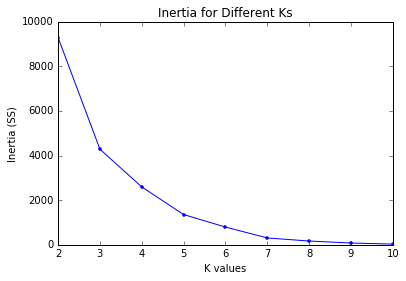

In [31]:
from sklearn.cluster import KMeans

f1 = find_clusters['capacity'].values
#f2 = find_clusters['average_duration'].values
f3 = find_clusters['ratio'].values
#f4 = find_clusters['territory'].values

M=np.matrix(zip(f1,f3))

SS = []

for k in range(2,11):
    cluster = KMeans(n_clusters=k)
    cluster.fit(M)
    SS.append(cluster.inertia_)

#Construct a plot showing SS for each K and pick K using this plot. For simplicity, test 2≤K≤10.
x_range = [2,3,4,5,6,7,8,9,10]

plt.plot(x_range, SS, marker='.')
plt.xlabel('K values')
plt.ylabel('Inertia (SS)')
plt.title('Inertia for Different Ks')
          
plt.show()

In [32]:
kmeans = KMeans(n_clusters=3, random_state=15).fit(M)
find_clusters['cluster_id'] = kmeans.labels_

In [33]:
find_clusters = find_clusters.reset_index()
data = data.merge(find_clusters[['start_station_id','cluster_id']], on='start_station_id')

In [34]:
print sp.stats.pearsonr(data.section, data.ratio)[0]
print sp.stats.pearsonr(data.group, data.ratio)[0]
print sp.stats.pearsonr(data.territory, data.ratio)[0]
print sp.stats.pearsonr(data.cluster_id, data.ratio)[0]

0.011303773707424317
0.07169074321281337
0.04651129437759224
0.04449979321872798


### As the groups based on number of trips is more strongly correlated with the in/out ratio, these groups will be used to separate the stations instead of the clusters.

In [35]:
group1 = data.loc[data.group == 1]
Xg1 = group1[['day_of_week', 'month_of_year', 'average_duration', 'capacity', 'territory']]
yg1 = group1['ratio']

group2 = data.loc[data.group == 2]
Xg2 = group2[['day_of_week', 'month_of_year', 'average_duration', 'capacity', 'territory']]
yg2 = group2['ratio']

group3 = data.loc[data.group == 3]
Xg3 = group3[['day_of_week', 'month_of_year', 'average_duration', 'capacity', 'territory']]
yg3 = group3['ratio']

group4 = data.loc[data.group == 4]
Xg4 = group4[['day_of_week', 'month_of_year', 'average_duration', 'capacity', 'territory']]
yg4 = group4['ratio']


### Feature Selection

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso

lasso = Lasso()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=15)

lasso_coef = lasso.fit(X_train,y_train).coef_

lasso_coef

array([-0.,  0.,  0., -0.,  0.,  0.])

None of the variables have strong coefficents, so we will use all predictor varibles while creating our models 

In [37]:
#prep categorical variables to utilize the get_dummies function
X.group = X.group.astype('category')
X.month_of_year = X.month_of_year.astype('category')
X.day_of_week = X.day_of_week.astype('category')
X.territory = X.territory.astype('category')

Xg1.month_of_year = Xg1.month_of_year.astype('category')
Xg1.day_of_week = Xg1.day_of_week.astype('category')
Xg1.territory = Xg1.territory.astype('category')

C:\Users\Danny\Miniconda2\envs\tutorial\lib\site-packages\pandas\core\generic.py:2387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [38]:
X = pd.get_dummies(X)
Xg1 = pd.get_dummies(Xg1)

### We will also need a baseline to compare our model against later on

This will allow us to see how well our models compare against just using the average ratio for each station for the year as a whole.

In [39]:
#count number of rides out per station for 2017
rout = df.groupby(['start_station_id']).count()

#count number of rides in per station for 2017
rin = df.groupby(['end_station_id']).count()

In [40]:
# get the infromation for trips in and trips out ready for a join
i = pd.DataFrame(rin.trip_id)
o = pd.DataFrame(rout.trip_id)
i.rename(columns={'trip_id': 'trips_in'}, inplace=True)
o.rename(columns={'trip_id': 'trips_out'}, inplace=True)
i.index.names = ['station_id']
o.index.names= ['station_id']

# join trips in and out into one dataframe
io = i.join(o, how='outer')
io['2017_ratio'] = io.trips_in / io.trips_out

io = io.drop(['trips_in', 'trips_out'], axis=1)
io = io.reset_index()

In [41]:
data = data.merge(io, left_on='start_station_id', right_on='station_id')
data = data.drop('station_id', axis=1)

### Now that we have our predictor and target variables, we can split the data into training and tests sets, and train a model. 

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [43]:
steps=[('scaler', StandardScaler()), ('reg', LinearRegression())]

pipeline = Pipeline(steps)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=15)
reg_scaled = pipeline.fit(X_train, y_train)

y_pred= pipeline.predict(X_test)

print pipeline.score(X_test, y_test)

0.007818453344142107


In [44]:
steps=[('scaler', StandardScaler()), ('reg', LinearRegression())]

pipeline = Pipeline(steps)

X_train, X_test, y_train, y_test = train_test_split(Xg1, yg1, test_size=.2, random_state=15)
reg_scaled = pipeline.fit(X_train, y_train)

y_pred= pipeline.predict(X_test)

print pipeline.score(X_test, y_test)

0.010888518518974766


In [45]:
steps=[('scaler', StandardScaler()), ('ridge', Ridge(alpha=.5, normalize=True))]

pipeline = Pipeline(steps)

parameters = {'ridge__alpha': [.1,.5,1,5,10]}

X_train, X_test, y_train, y_test = train_test_split(Xg1, yg1, test_size=.2, random_state=15)

cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)

cv.fit(X_train, y_train)

print cv.best_params_

{'ridge__alpha': 0.1}


In [46]:
steps=[('scaler', StandardScaler()), ('ridge', Ridge(alpha=.1, normalize=True))]

pipeline = Pipeline(steps)

X_train, X_test, y_train, y_test = train_test_split(Xg1, yg1, test_size=.2, random_state=15)
reg_scaled = pipeline.fit(X_train, y_train)

y_pred= pipeline.predict(X_test)

print pipeline.score(X_test, y_test)

0.011069049176805179


### What if we separated out the target variable into classes that can be used for different stocking recommendations, and used our data for classification?

These stocking classes will be based on the trips in to trips out ratio, and will be separated in a way that a different recommendation can be made about stocking requirements for each class.

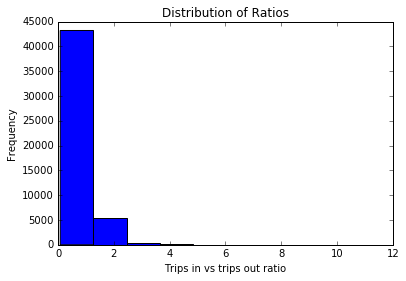

In [47]:
#view the distribution for the ratios - most seem to fall between 0 and 2
plt.hist(data.ratio)
plt.xlabel('Trips in vs trips out ratio')
plt.ylabel('Frequency')
plt.title('Distribution of Ratios')
plt.show()

In [48]:
#separate the stock classes - different ratios would require different degrees of stocking needs

stockclass= []

def separate_stockclass():
    for i in range(len(c.ratio)):
        if data.ratio[i] < .5:
            stockclass.append('0 to .5')
        elif data.ratio[i] < .8:
            stockclass.append('.5 to .8')
        elif data.ratio[i] < 1.2:
            stockclass.append('.8 to 1.2')
        elif data.ratio[i] < 2.5:
            stockclass.append('1.2 to 2.5')
        elif data.ratio[i] >= 2.5:
            stockclass.append('2.5+')
        else:
            return 'Error'

In [49]:
separate_stockclass()

In [50]:
#new predictor and target variables for classification
data['class'] = stockclass
yc = data['class']
Xc = data[['day_of_week', 'month_of_year', 'average_duration', 'group', 'capacity', 'territory']]

#update the grouped predictor and target variables
g1c = group1[['day_of_week', 'month_of_year', 'average_duration', 'capacity', 'territory']]
g1yc = data['class'].loc[data.group == 1]
g2c = group2[['day_of_week', 'month_of_year', 'average_duration', 'capacity', 'territory']]
g2yc = data['class'].loc[data.group == 2]
g3c = group3[['day_of_week', 'month_of_year', 'average_duration', 'capacity', 'territory']]
g3yc = data['class'].loc[data.group == 3]
g4c = group4[['day_of_week', 'month_of_year', 'average_duration', 'capacity', 'territory']]
g4yc = data['class'].loc[data.group == 4]

### Create benchmarks to help evaluate our models going forward

In [51]:
#look at baseline performance for these new classes. As mentioned previously the average ratio per station for the year will act
#as our benchmark
baseline_results= []

def baseline():
    for i in range(len(c.ratio)):
        if data['2017_ratio'][i] < .5:
            baseline_results.append('0 to .5')
        elif data['2017_ratio'][i] < .8:
            baseline_results.append('.5 to .8')
        elif data['2017_ratio'][i] < 1.2:
            baseline_results.append('.8 to 1.2')
        elif data['2017_ratio'][i] < 2.5:
            baseline_results.append('1.2 to 2.5')
        elif data['2017_ratio'][i] >= 2.5:
            baseline_results.append('2.5+')
        else:
            return 'Error'


In [52]:
baseline()
data['baseline'] = baseline_results

In [53]:
#update the grouped dfs to include the class and baseline variables
group1 = data.loc[data.group == 1]
group2 = data.loc[data.group == 2]
group3 = data.loc[data.group == 3]
group4 = data.loc[data.group == 4]

In [54]:
#baseline performance for non-group model
a = data['class'].loc[data['class'] == data['baseline']]
float(len(a))/len(data)

0.6846764346764347

In [55]:
print classification_report(data['class'], data['baseline'])


             precision    recall  f1-score   support

   .5 to .8       0.23      0.06      0.10      5502
  .8 to 1.2       0.72      0.94      0.81     34657
    0 to .5       0.24      0.02      0.04       919
 1.2 to 2.5       0.34      0.09      0.15      7482
       2.5+       0.05      0.01      0.01       580

avg / total       0.59      0.68      0.61     49140



In [56]:
#baseline performance for group1
a = group1['class'].loc[group1['class'] == group1['baseline']]
float(len(a))/len(group1)

0.8603012633624878

In [57]:
print classification_report(group1['class'], group1['baseline'])

             precision    recall  f1-score   support

   .5 to .8       0.70      0.15      0.24       802
  .8 to 1.2       0.87      0.99      0.92     10509
    0 to .5       0.00      0.00      0.00        12
 1.2 to 2.5       0.61      0.10      0.17      1020
       2.5+       0.00      0.00      0.00         5

avg / total       0.83      0.86      0.82     12348



C:\Users\Danny\Miniconda2\envs\tutorial\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [58]:
#baseline performance for group2
a = group2['class'].loc[group2['class'] == group2['baseline']]
float(len(a))/len(group2)

0.7534246575342466

In [59]:
print classification_report(group2['class'], group2['baseline'])

             precision    recall  f1-score   support

   .5 to .8       0.71      0.05      0.09      1183
  .8 to 1.2       0.76      1.00      0.86      9176
    0 to .5       0.00      0.00      0.00        29
 1.2 to 2.5       0.56      0.03      0.05      1869
       2.5+       0.00      0.00      0.00         7

avg / total       0.72      0.75      0.66     12264



In [60]:
#baseline performance for group3
a = group3['class'].loc[group3['class'] == group3['baseline']]
float(len(a))/len(group3)

0.5448467058056099

In [61]:
print classification_report(group3['class'], group3['baseline'])

             precision    recall  f1-score   support

   .5 to .8       0.00      0.00      0.00      2097
  .8 to 1.2       0.54      0.98      0.70      6575
    0 to .5       0.00      0.00      0.00       333
 1.2 to 2.5       0.56      0.08      0.14      3045
       2.5+       0.00      0.00      0.00       214

avg / total       0.43      0.54      0.41     12264



In [62]:
#baseline performance for group4
a = group4['class'].loc[group4['class'] == group4['baseline']]
float(len(a))/len(group4)

0.5789302022178735

In [63]:
print classification_report(group3['class'], group3['baseline'])

             precision    recall  f1-score   support

   .5 to .8       0.00      0.00      0.00      2097
  .8 to 1.2       0.54      0.98      0.70      6575
    0 to .5       0.00      0.00      0.00       333
 1.2 to 2.5       0.56      0.08      0.14      3045
       2.5+       0.00      0.00      0.00       214

avg / total       0.43      0.54      0.41     12264



## KNN

In [64]:
steps=[('knn', KNeighborsClassifier())]

pipeline = Pipeline(steps)

parameters = {'knn__n_neighbors':np.arange(9,25)}

X_train, X_test, y_train, y_test = train_test_split(Xc, yc, test_size=.2, random_state=15)

cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)

cv.fit(X_train, y_train)

print cv.best_params_

{'knn__n_neighbors': 24}


In [65]:
clf = KNeighborsClassifier(n_neighbors= 24)
X_train, X_test, y_train, y_test = train_test_split(Xc, yc, test_size=.2, random_state=15)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print "Training score: ", clf.score(X_train, y_train)
print "Test score: ", clf.score(X_test, y_test)

print classification_report(y_test, y_pred)

Training score:  0.7105718355718356
Test score:  0.700956450956451
             precision    recall  f1-score   support

   .5 to .8       0.26      0.04      0.07      1104
  .8 to 1.2       0.72      0.98      0.83      6935
    0 to .5       0.00      0.00      0.00       186
 1.2 to 2.5       0.31      0.04      0.07      1482
       2.5+       0.00      0.00      0.00       121

avg / total       0.58      0.70      0.60      9828



Group 1

In [66]:
steps=[('knn', KNeighborsClassifier())]

pipeline = Pipeline(steps)

parameters = {'knn__n_neighbors':np.arange(9,25)}

X_train, X_test, y_train, y_test = train_test_split(g1c, g1yc, test_size=.2, random_state=15)

cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)

cv.fit(X_train, y_train)

print cv.best_params_

{'knn__n_neighbors': 18}


In [67]:
clf = KNeighborsClassifier(n_neighbors= 18)
X_train, X_test, y_train, y_test = train_test_split(g1c, g1yc, test_size=.2, random_state=15)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print "Training score: ", clf.score(X_train, y_train)
print "Test score: ", clf.score(X_test, y_test)

print classification_report(y_test, y_pred)

Training score:  0.8552338530066815
Test score:  0.8437246963562753
             precision    recall  f1-score   support

   .5 to .8       0.78      0.04      0.07       193
  .8 to 1.2       0.84      1.00      0.92      2079
    0 to .5       0.00      0.00      0.00         2
 1.2 to 2.5       0.00      0.00      0.00       196

avg / total       0.77      0.84      0.78      2470



Group 2

In [68]:
steps=[('knn', KNeighborsClassifier())]

pipeline = Pipeline(steps)

parameters = {'knn__n_neighbors':np.arange(9,25)}

X_train, X_test, y_train, y_test = train_test_split(g2c, g2yc, test_size=.2, random_state=15)

cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)

cv.fit(X_train, y_train)

print cv.best_params_

{'knn__n_neighbors': 24}


In [69]:
clf = KNeighborsClassifier(n_neighbors= 24)
X_train, X_test, y_train, y_test = train_test_split(g2c, g2yc, test_size=.2, random_state=15)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print "Training score: ", clf.score(X_train, y_train)
print "Test score: ", clf.score(X_test, y_test)

print classification_report(y_test, y_pred)

Training score:  0.7562939557639384
Test score:  0.7403179779861394
             precision    recall  f1-score   support

   .5 to .8       0.75      0.05      0.09       251
  .8 to 1.2       0.74      0.99      0.85      1813
    0 to .5       0.00      0.00      0.00         7
 1.2 to 2.5       0.25      0.01      0.02       381
       2.5+       0.00      0.00      0.00         1

avg / total       0.66      0.74      0.64      2453



Group 3

In [70]:
steps=[('knn', KNeighborsClassifier())]

pipeline = Pipeline(steps)

parameters = {'knn__n_neighbors':np.arange(9,25)}

X_train, X_test, y_train, y_test = train_test_split(g3c, g3yc, test_size=.2, random_state=15)

cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)

cv.fit(X_train, y_train)

print cv.best_params_

{'knn__n_neighbors': 24}


In [71]:
clf = KNeighborsClassifier(n_neighbors= 24)
X_train, X_test, y_train, y_test = train_test_split(g3c, g3yc, test_size=.2, random_state=15)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print "Training score: ", clf.score(X_train, y_train)
print "Test score: ", clf.score(X_test, y_test)

print classification_report(y_test, y_pred)

Training score:  0.5540719600448476
Test score:  0.5165103954341622
             precision    recall  f1-score   support

   .5 to .8       0.20      0.06      0.09       440
  .8 to 1.2       0.55      0.90      0.68      1299
    0 to .5       0.00      0.00      0.00        64
 1.2 to 2.5       0.39      0.12      0.18       609
       2.5+       0.00      0.00      0.00        41

avg / total       0.42      0.52      0.42      2453



Group 4 

In [72]:
steps=[('knn', KNeighborsClassifier())]

pipeline = Pipeline(steps)

parameters = {'knn__n_neighbors':np.arange(9,25)}

X_train, X_test, y_train, y_test = train_test_split(g4c, g4yc, test_size=.2, random_state=15)

cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)

cv.fit(X_train, y_train)

print cv.best_params_

{'knn__n_neighbors': 24}


In [73]:
clf = KNeighborsClassifier(n_neighbors= 24)
X_train, X_test, y_train, y_test = train_test_split(g4c, g4yc, test_size=.2, random_state=15)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print "Training score: ", clf.score(X_train, y_train)
print "Test score: ", clf.score(X_test, y_test)

print classification_report(y_test, y_pred)

Training score:  0.693507287738253
Test score:  0.6632694659600489
             precision    recall  f1-score   support

   .5 to .8       0.24      0.09      0.13       295
  .8 to 1.2       0.70      0.94      0.81      1681
    0 to .5       0.00      0.00      0.00        95
 1.2 to 2.5       0.19      0.06      0.09       310
       2.5+       0.00      0.00      0.00        72

avg / total       0.54      0.66      0.58      2453



## Random Forest

In [74]:
from sklearn.ensemble import RandomForestClassifier

steps=[('rf', RandomForestClassifier())]

pipeline = Pipeline(steps)

parameters = {'rf__n_estimators':np.arange(5,20)}

X_train, X_test, y_train, y_test = train_test_split(Xc, yc, test_size=.2, random_state=15)

cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)

cv.fit(X_train, y_train)

print cv.best_params_
print cv.best_score_

{'rf__n_estimators': 16}
0.6426790801790802


C:\Users\Danny\Miniconda2\envs\tutorial\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [75]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=14)
X_train, X_test, y_train, y_test = train_test_split(Xc, yc, test_size=.2, random_state=18)
clf.fit(X_train, y_train)


print "Training score: ", clf.score(X_train, y_train)
print "Test score: ", clf.score(X_test, y_test)

y_pred = clf.predict(X_test)
print classification_report(y_test, y_pred)

Training score:  0.9828296703296703
Test score:  0.6386853886853887
             precision    recall  f1-score   support

   .5 to .8       0.20      0.17      0.18      1086
  .8 to 1.2       0.76      0.84      0.80      6942
    0 to .5       0.07      0.05      0.06       186
 1.2 to 2.5       0.25      0.17      0.20      1507
       2.5+       0.05      0.03      0.04       107

avg / total       0.60      0.64      0.61      9828



Group 1

In [76]:

steps=[('rf', RandomForestClassifier())]

pipeline = Pipeline(steps)

parameters = {'rf__n_estimators':np.arange(5,20)}

X_train, X_test, y_train, y_test = train_test_split(g1c, g1yc, test_size=.2, random_state=15)

cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)

cv.fit(X_train, y_train)

print cv.best_params_
print cv.best_score_

{'rf__n_estimators': 19}
0.8364041303907673


In [77]:
clf = RandomForestClassifier(n_estimators=15)
X_train, X_test, y_train, y_test = train_test_split(g1c, g1yc, test_size=.2, random_state=18)
clf.fit(X_train, y_train)


print "Training score: ", clf.score(X_train, y_train)
print "Test score: ", clf.score(X_test, y_test)

y_pred = clf.predict(X_test)
print classification_report(y_test, y_pred)

Training score:  0.989167847742458
Test score:  0.8170040485829959
             precision    recall  f1-score   support

   .5 to .8       0.41      0.20      0.27       172
  .8 to 1.2       0.86      0.95      0.90      2080
    0 to .5       0.00      0.00      0.00         1
 1.2 to 2.5       0.15      0.06      0.09       214
       2.5+       0.00      0.00      0.00         3

avg / total       0.76      0.82      0.78      2470



Group 2

In [78]:
steps=[('rf', RandomForestClassifier())]

pipeline = Pipeline(steps)

parameters = {'rf__n_estimators':np.arange(5,20)}

X_train, X_test, y_train, y_test = train_test_split(g2c, g2yc, test_size=.2, random_state=15)

cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)

cv.fit(X_train, y_train)

print cv.best_params_
print cv.best_score_

{'rf__n_estimators': 19}
0.6917745387829987


In [79]:
clf = RandomForestClassifier(n_estimators=12)
X_train, X_test, y_train, y_test = train_test_split(g2c, g2yc, test_size=.2, random_state=18)
clf.fit(X_train, y_train)


print "Training score: ", clf.score(X_train, y_train)
print "Test score: ", clf.score(X_test, y_test)

y_pred = clf.predict(X_test)
print classification_report(y_test, y_pred)

Training score:  0.9776781163999593
Test score:  0.6820220138605789
             precision    recall  f1-score   support

   .5 to .8       0.23      0.16      0.19       259
  .8 to 1.2       0.77      0.86      0.81      1827
    0 to .5       0.00      0.00      0.00         4
 1.2 to 2.5       0.24      0.15      0.18       363

avg / total       0.63      0.68      0.65      2453



Group 3

In [80]:
steps=[('rf', RandomForestClassifier())]

pipeline = Pipeline(steps)

parameters = {'rf__n_estimators':np.arange(5,20)}

X_train, X_test, y_train, y_test = train_test_split(g3c, g3yc, test_size=.2, random_state=15)

cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)

cv.fit(X_train, y_train)

print cv.best_params_
print cv.best_score_

{'rf__n_estimators': 17}
0.44582611354601975


In [81]:
clf = RandomForestClassifier(n_estimators=19)
X_train, X_test, y_train, y_test = train_test_split(g3c, g3yc, test_size=.2, random_state=18)
clf.fit(X_train, y_train)


print "Training score: ", clf.score(X_train, y_train)
print "Test score: ", clf.score(X_test, y_test)

y_pred = clf.predict(X_test)
print classification_report(y_test, y_pred)

Training score:  0.9871572724492916
Test score:  0.437015898899307
             precision    recall  f1-score   support

   .5 to .8       0.19      0.14      0.16       454
  .8 to 1.2       0.56      0.67      0.61      1276
    0 to .5       0.02      0.02      0.02        57
 1.2 to 2.5       0.29      0.25      0.27       620
       2.5+       0.00      0.00      0.00        46

avg / total       0.40      0.44      0.42      2453



Group 4

In [82]:
steps=[('rf', RandomForestClassifier())]

pipeline = Pipeline(steps)

parameters = {'rf__n_estimators':np.arange(5,20)}

X_train, X_test, y_train, y_test = train_test_split(g4c, g4yc, test_size=.2, random_state=15)

cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)

cv.fit(X_train, y_train)

print cv.best_params_
print cv.best_score_

{'rf__n_estimators': 18}
0.625420446437672


In [83]:
clf = RandomForestClassifier(n_estimators=6)
X_train, X_test, y_train, y_test = train_test_split(g4c, g4yc, test_size=.2, random_state=18)
clf.fit(X_train, y_train)


print "Training score: ", clf.score(X_train, y_train)
print "Test score: ", clf.score(X_test, y_test)

y_pred = clf.predict(X_test)
print classification_report(y_test, y_pred)

Training score:  0.9551523799816533
Test score:  0.6078271504280472
             precision    recall  f1-score   support

   .5 to .8       0.25      0.24      0.24       310
  .8 to 1.2       0.76      0.82      0.79      1639
    0 to .5       0.09      0.07      0.08       111
 1.2 to 2.5       0.24      0.19      0.21       316
       2.5+       0.11      0.05      0.07        77

avg / total       0.58      0.61      0.59      2453



## SVM

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(g1c, g1yc, test_size=.2, random_state=15)

Cs = [0.001, 0.01, 0.1, 1, 10, 50, 100]
gammas = [0.001, 0.01, 0.1, 1]
param_grid = {'C': Cs, 'gamma' : gammas}
cv = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=5)
cv.fit(X_train, y_train)

print cv.best_params_

Group 1

In [84]:
from sklearn import svm

clf = svm.SVC(gamma=.001, C=100)

X_train, X_test, y_train, y_test = train_test_split(g1c, g1yc, test_size=.2, random_state=15)
clf.fit(X_train, y_train)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [85]:
print "Training score: ", clf.score(X_train, y_train)
print "Test score: ", clf.score(X_test, y_test)
y_pred = clf.predict(X_test)
print classification_report(y_test, y_pred)

Training score:  0.8537153269892691
Test score:  0.8421052631578947
             precision    recall  f1-score   support

   .5 to .8       0.00      0.00      0.00       193
  .8 to 1.2       0.84      1.00      0.91      2079
    0 to .5       0.00      0.00      0.00         2
 1.2 to 2.5       1.00      0.01      0.01       196

avg / total       0.79      0.84      0.77      2470



Group 2

In [86]:
clf = svm.SVC(gamma=0.001, C=100)

X_train, X_test, y_train, y_test = train_test_split(g2c, g2yc, test_size=.2, random_state=15)
clf.fit(X_train, y_train)
#y_pred = clf.predict(X_test)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [87]:
print "Training score: ", clf.score(X_train, y_train)
print "Test score: ", clf.score(X_test, y_test)
y_pred = clf.predict(X_test)
print classification_report(y_test, y_pred)

Training score:  0.7548669860360819
Test score:  0.7431716265796984
             precision    recall  f1-score   support

   .5 to .8       0.80      0.05      0.09       251
  .8 to 1.2       0.74      1.00      0.85      1813
    0 to .5       0.00      0.00      0.00         7
 1.2 to 2.5       0.00      0.00      0.00       381
       2.5+       0.00      0.00      0.00         1

avg / total       0.63      0.74      0.64      2453



Group 3

In [88]:
clf = svm.SVC(gamma=0.001, C=100.)

X_train, X_test, y_train, y_test = train_test_split(g3c, g3yc, test_size=.2, random_state=15)
clf.fit(X_train, y_train)
#y_pred = clf.predict(X_test)

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [89]:
print "Training score: ", clf.score(X_train, y_train)
print "Test score: ", clf.score(X_test, y_test)
y_pred = clf.predict(X_test)
print classification_report(y_test, y_pred)

Training score:  0.5389868514932219
Test score:  0.5283326538931921
             precision    recall  f1-score   support

   .5 to .8       0.00      0.00      0.00       440
  .8 to 1.2       0.53      1.00      0.69      1299
    0 to .5       0.00      0.00      0.00        64
 1.2 to 2.5       0.20      0.00      0.00       609
       2.5+       0.00      0.00      0.00        41

avg / total       0.33      0.53      0.37      2453



Group 4

In [90]:
clf = svm.SVC(gamma=0.001, C=100.)

X_train, X_test, y_train, y_test = train_test_split(g4c, g4yc, test_size=.2, random_state=15)
clf.fit(X_train, y_train)
#y_pred = clf.predict(X_test)

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [91]:
print "Training score: ", clf.score(X_train, y_train)
print "Test score: ", clf.score(X_test, y_test)
y_pred = clf.predict(X_test)
print classification_report(y_test, y_pred)

Training score:  0.6884109672816227
Test score:  0.6856909906237261
             precision    recall  f1-score   support

   .5 to .8       0.67      0.01      0.01       295
  .8 to 1.2       0.69      1.00      0.81      1681
    0 to .5       1.00      0.01      0.02        95
 1.2 to 2.5       0.00      0.00      0.00       310
       2.5+       0.00      0.00      0.00        72

avg / total       0.59      0.69      0.56      2453



## Multinomial NB

In [92]:
from sklearn.naive_bayes import MultinomialNB

steps=[('MNB', MultinomialNB())]

pipeline = Pipeline(steps)

parameters = {'MNB__alpha':np.arange(1,10)}

#using X on this model because X has the dummy columns added in
X_train, X_test, y_train, y_test = train_test_split(X, yc, test_size=.2, random_state=15)

cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)

cv.fit(X_train, y_train)

print cv.best_params_
print cv.best_score_

{'MNB__alpha': 9}
0.6655982905982906


In [93]:
clf = MultinomialNB(alpha=9)

X_train, X_test, y_train, y_test = train_test_split(Xc, yc, test_size=.2, random_state=18)
clf.fit(X_train, y_train)


print "Training score: ", clf.score(X_train, y_train)
print "Test score: ", clf.score(X_test, y_test)

y_pred = clf.predict(X_test)
print classification_report(y_test, y_pred)

Training score:  0.6722629222629223
Test score:  0.6713471713471714
             precision    recall  f1-score   support

   .5 to .8       0.17      0.03      0.05      1086
  .8 to 1.2       0.72      0.93      0.81      6942
    0 to .5       0.07      0.04      0.05       186
 1.2 to 2.5       0.19      0.06      0.09      1507
       2.5+       0.00      0.00      0.00       107

avg / total       0.56      0.67      0.59      9828



In [94]:
g1cd = pd.get_dummies(g1c)
g2cd = pd.get_dummies(g2c)
g3cd = pd.get_dummies(g3c)
g4cd = pd.get_dummies(g4c)

Group 1

In [95]:
steps=[('MNB', MultinomialNB())]

pipeline = Pipeline(steps)

parameters = {'MNB__alpha':np.arange(1,10)}

#using X on this model because X has the dummy columns added in
X_train, X_test, y_train, y_test = train_test_split(g1c, g1yc, test_size=.2, random_state=15)

cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)

cv.fit(X_train, y_train)

print cv.best_params_
print cv.best_score_

{'MNB__alpha': 5}
0.8534116217857866


In [96]:
clf = MultinomialNB(alpha=5)

X_train, X_test, y_train, y_test = train_test_split(g1cd, g1yc, test_size=.2, random_state=18)
clf.fit(X_train, y_train)


print "Training score: ", clf.score(X_train, y_train)
print "Test score: ", clf.score(X_test, y_test)

y_pred = clf.predict(X_test)
print classification_report(y_test, y_pred)

Training score:  0.8533103867179591
Test score:  0.8421052631578947
             precision    recall  f1-score   support

   .5 to .8       0.00      0.00      0.00       172
  .8 to 1.2       0.84      1.00      0.91      2080
    0 to .5       0.00      0.00      0.00         1
 1.2 to 2.5       0.00      0.00      0.00       214
       2.5+       0.00      0.00      0.00         3

avg / total       0.71      0.84      0.77      2470



Group 2

In [97]:
steps=[('MNB', MultinomialNB())]

pipeline = Pipeline(steps)

parameters = {'MNB__alpha':np.arange(1,10)}

#using X on this model because X has the dummy columns added in
X_train, X_test, y_train, y_test = train_test_split(g2c, g2yc, test_size=.2, random_state=15)

cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)

cv.fit(X_train, y_train)

print cv.best_params_
print cv.best_score_

{'MNB__alpha': 3}
0.7479359902150647


In [98]:
clf = MultinomialNB(alpha=3)

X_train, X_test, y_train, y_test = train_test_split(g2cd, g2yc, test_size=.2, random_state=18)
clf.fit(X_train, y_train)


print "Training score: ", clf.score(X_train, y_train)
print "Test score: ", clf.score(X_test, y_test)

y_pred = clf.predict(X_test)
print classification_report(y_test, y_pred)

Training score:  0.7440627866680257
Test score:  0.7386873216469629
             precision    recall  f1-score   support

   .5 to .8       0.00      0.00      0.00       259
  .8 to 1.2       0.74      0.99      0.85      1827
    0 to .5       0.00      0.00      0.00         4
 1.2 to 2.5       0.00      0.00      0.00       363
       2.5+       0.00      0.00      0.00         0

avg / total       0.55      0.74      0.63      2453



C:\Users\Danny\Miniconda2\envs\tutorial\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Group 3

In [99]:
steps=[('MNB', MultinomialNB())]

pipeline = Pipeline(steps)

parameters = {'MNB__alpha':np.arange(1,10)}

#using X on this model because X has the dummy columns added in
X_train, X_test, y_train, y_test = train_test_split(g3c, g3yc, test_size=.2, random_state=15)

cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)

cv.fit(X_train, y_train)

print cv.best_params_
print cv.best_score_

{'MNB__alpha': 1}
0.5358271328101111


In [100]:
clf = MultinomialNB(alpha=1)

X_train, X_test, y_train, y_test = train_test_split(g3cd, g3yc, test_size=.2, random_state=18)
clf.fit(X_train, y_train)


print "Training score: ", clf.score(X_train, y_train)
print "Test score: ", clf.score(X_test, y_test)

y_pred = clf.predict(X_test)
print classification_report(y_test, y_pred)

Training score:  0.5359290592192437
Test score:  0.5144720750101917
             precision    recall  f1-score   support

   .5 to .8       0.00      0.00      0.00       454
  .8 to 1.2       0.52      0.99      0.68      1276
    0 to .5       0.00      0.00      0.00        57
 1.2 to 2.5       0.17      0.01      0.02       620
       2.5+       0.00      0.00      0.00        46

avg / total       0.31      0.51      0.36      2453



Group 4

In [101]:
steps=[('MNB', MultinomialNB())]

pipeline = Pipeline(steps)

parameters = {'MNB__alpha':np.arange(1,10)}

#using X on this model because X has the dummy columns added in
X_train, X_test, y_train, y_test = train_test_split(g4c, g4yc, test_size=.2, random_state=15)

cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)

cv.fit(X_train, y_train)

print cv.best_params_
print cv.best_score_

{'MNB__alpha': 1}
0.6212414636632352


In [102]:
clf = MultinomialNB(alpha=1)

X_train, X_test, y_train, y_test = train_test_split(g4c, g4yc, test_size=.2, random_state=18)
clf.fit(X_train, y_train)


print "Training score: ", clf.score(X_train, y_train)
print "Test score: ", clf.score(X_test, y_test)

y_pred = clf.predict(X_test)
print classification_report(y_test, y_pred)

Training score:  0.6271531953929264
Test score:  0.6045658377496943
             precision    recall  f1-score   support

   .5 to .8       0.20      0.14      0.16       310
  .8 to 1.2       0.72      0.84      0.78      1639
    0 to .5       0.00      0.00      0.00       111
 1.2 to 2.5       0.20      0.20      0.20       316
       2.5+       0.00      0.00      0.00        77

avg / total       0.53      0.60      0.56      2453



## Compare Performance from models

In [103]:
sns.set()

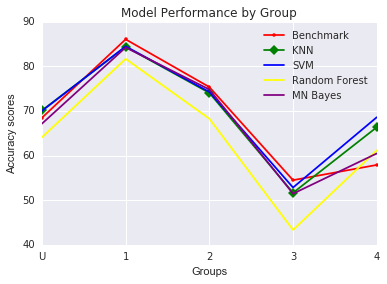

In [104]:

knn = [70.1,84.37,74.03,51.65,66.33]
svm = [70,84.45,74.25,52.83,68.57]
randomforest = [64.08,81.66,68.24,43.33,61.15]
MNbayes = [67.13,84.21,74.79,51.45,60.46]
benchmark = [68.46,86.03,75.34,54.48,57.89]
xaxis = [1,2,3,4,5]

plt.plot(xaxis, benchmark, marker='.', color='red', label='Benchmark')
plt.plot(xaxis, knn, marker='D', color='green', label='KNN')
plt.plot(xaxis, svm, color='blue', label='SVM')
plt.plot(xaxis, randomforest, color='yellow', label='Random Forest')
plt.plot(xaxis, MNbayes, color='purple', label='MN Bayes')
plt.xticks([1, 2, 3, 4, 5], ['U', 1,2,3,4,5])
plt.legend(loc='upper right')
plt.xlabel('Groups')
plt.ylabel('Accuracy scores')
plt.title('Model Performance by Group')
plt.show()


